# Retrievability Analysis on TREC GOV2 Collection #

This notebook covers the analysis published in CIKM '17 paper "An Empirical Analysis of Pruning Techniques".

## Front Matter ##

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats

matplotlib.rcParams.update({'font.size': 12})

screen_name = {'dcp': 'DCP',
               'infinite_renyi': 'REN',
               'tcp': 'TCP',
               'up': 'UP'}

metric_name = {'n@5': 'NDCG@5',
               'n@10': 'NDCG@10',
               'n@20': 'NDCG@20',
               'p@5': 'P@5',
               'p@10': 'P@10',
               'p@20': 'P@20',
               'mrr': 'MRR',
               'map': 'MAP',
               'gini': 'Gini index',
               'r_sum': 'RSUM',
               'time': 'Query execution time (s)'}

def get_metric(df, p_method, metric):
    return df[df.p_method.isin([p_method, 'full_index'])][['p_ratio', metric]].reset_index()

def expand_lim(lim, fraction, offset=0):
    assert 0 <= fraction <= 1
    gap = 0.5 * fraction * (lim[1] - lim[0])
    return lim[0] - gap + offset, lim[1] + gap + offset

## Load the Data ##

Load the results in and split the data into subframes, with each frame organized for plotting

In [2]:
df = pd.read_csv('gov2.csv', index_col=0)
df = df[df.measure == 'gm_0.5']
baseline = df[df.p_method == 'full_index']
subdf = {}
for metric in ['n@5', 'n@10', 'n@20', 'p@5', 'p@10', 'p@20', 'mrr', 'map', 'r_sum', 'gini', 'time']:
    data = {screen_name[m]: get_metric(df, m, metric).sort_values(by='p_ratio')[metric]
            for m in ['dcp', 'infinite_renyi', 'tcp', 'up']}
    data['p_ratio'] = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    subdf[metric] = pd.DataFrame(data)

In [3]:
subdf['gini']

,DCP,REN,TCP,UP,p_ratio
0,0.992705,0.992705,0.992705,0.992705,0.0
1,0.992638,0.992638,0.992727,0.992717,0.1
2,0.992627,0.992628,0.992717,0.992747,0.2
3,0.992634,0.992635,0.992672,0.992779,0.3
4,0.992651,0.992653,0.992561,0.992848,0.4
5,0.992681,0.992685,0.992410,0.992987,0.5
6,0.992743,0.992753,0.992218,0.993248,0.6
7,0.992913,0.992931,0.991998,0.993958,0.7
8,0.993343,0.993372,0.992086,0.995595,0.8
9,0.994470,0.994486,0.993917,0.996891,0.9


## Figure 1 ##

The following code plots various metrics with respect to p-ratio (prune ratio).

Five metrics are reported in this figure: MAP, NDCG@10, query execution time, Gini coefficient, and total retrievability (or RSUM, $\sum_d r(d)$)

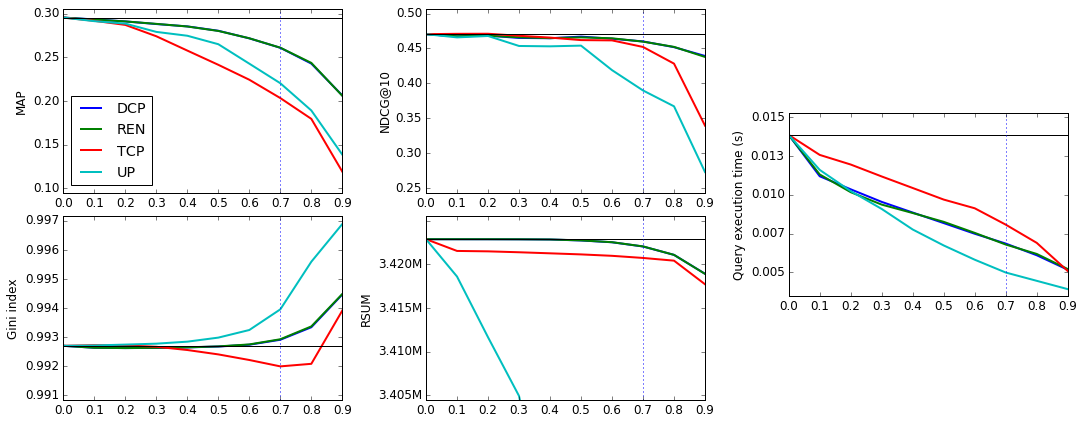

In [4]:
fig = plt.figure(figsize=(18, 7))
axes = [
    plt.subplot2grid((4, 3), (0, 0), rowspan=2),
    plt.subplot2grid((4, 3), (0, 1), rowspan=2),
    plt.subplot2grid((4, 3), (1, 2), rowspan=2),
    plt.subplot2grid((4, 3), (2, 0), rowspan=2),
    plt.subplot2grid((4, 3), (2, 1), rowspan=2)
]

for k, m in enumerate(['map', 'n@10', 'time', 'gini', 'r_sum']):
    legend = k in [0]
    ax = axes[k]
    subdf[m].plot(ax=ax, x='p_ratio', legend=legend, lw=2)
    ax.axhline(baseline[m].iloc[0], color='black')
    ax.set(xlabel='', ylabel=metric_name[m])
    ymin, ymax = ax.get_ylim()
    ax.axvline(x=0.7, linestyle='dotted')

    if m == 'r_sum':
        ax.set_ylim(3400000, 3420000)
        vals = ax.get_yticks()
        ax.set_yticklabels(['{:1.3f}M'.format(float(x) / 1000000) for x in vals])
    elif m == 'time':
        # divide by 200k to get the per-query number
        vals = ax.get_yticks()
        ax.set_yticklabels(['{:1.3f}'.format(float(x) / 200000) for x in vals])
    ax.set_ylim(expand_lim(ax.get_ylim(), 0.05))

fig.subplots_adjust(hspace=0.3, wspace=0.3)
fig.savefig('effectiveness-to-prune-ratio.png', bbox_inches='tight')

## Figure 2 ##

The following code plots MAP and NDCG@10 with respect to the Gini coefficient; the NDCG@10-Gini plot also comes with a zoomed-in view.

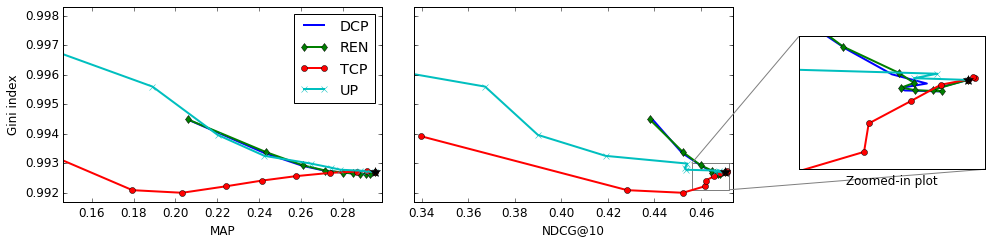

In [5]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, axes = plt.subplots(ncols=2, nrows=1, sharey=True, figsize=(12, 3.5))
ax_ins = zoomed_inset_axes(axes[-1], 5, loc=1,
                           bbox_to_anchor=(1.2, 0.81), bbox_transform=fig.transFigure)
    
for k, metric in enumerate(['map', 'n@10']):
    ax = axes[k]
    for m, style in zip(['dcp', 'infinite_renyi', 'tcp', 'up'], ['-', 'd-', 'o-', 'x-']):
        data = get_metric(df, m, metric).sort_values(by='p_ratio')[metric]
        gini = get_metric(df, m, 'gini').sort_values(by='p_ratio')['gini']
        p_ratio = get_metric(df, m, 'gini').sort_values(by='p_ratio')['p_ratio']
        frame = pd.DataFrame({'metric': data,
                              'gini': gini, 
                              'p_ratio': p_ratio})
        
        frame.sort_values(by='p_ratio', ascending=False).plot(
            ax=ax, x='metric', y='gini', label=screen_name[m],
            legend=False, style=style, lw=2)
        if metric == 'n@10':
            frame.sort_values(by='p_ratio', ascending=False).plot(
                ax=ax_ins, x='metric', y='gini', label=screen_name[m],
                legend=False, style=style, lw=2)
            
    if metric == 'map':
        ax.set_xlim(0.15, ax.get_xlim()[1])
    elif metric == 'n@10':
        ax.set_xlim(0.34, ax.get_xlim()[1])
        ax_ins.set_xlim(0.456, 0.472)
        ax_ins.set_ylim(0.9921, 0.993)
        ax_ins.xaxis.set_ticks([])
        ax_ins.yaxis.set_ticks([])
        ax_ins.set_xlabel('Zoomed-in plot')
 
    ax.set_xlim(expand_lim(ax.get_xlim(), 0.05))
    ax.set_ylim(expand_lim(ax.get_ylim(), 0.05, offset=0.0005))

    if metric == 'map':
        lines, labels = ax.get_legend_handles_labels()
        ax.legend(lines, labels, loc='best')
    ax.set(xlabel=metric_name[metric], ylabel='Gini index')
    ax.plot(baseline[metric].iloc[0], baseline['gini'].iloc[0], marker='*', markersize=10, color='black')
    if metric == 'n@10':
        ax_ins.plot(baseline[metric].iloc[0], baseline['gini'].iloc[0], marker='*', markersize=10, color='black')

fig.subplots_adjust(wspace=0.1)
plt.setp([axes[-1].get_yticklabels(), ax_ins.get_xticklabels(), ax_ins.get_yticklabels()], visible=False)
mark_inset(axes[-1], ax_ins, loc1=2, loc2=4, fc="none", ec="0.5")
    
fig.savefig('gini-to-metric.png', bbox_inches='tight')

## Appendix ##

Some additional plots to complement Figure 1 with more metrics.

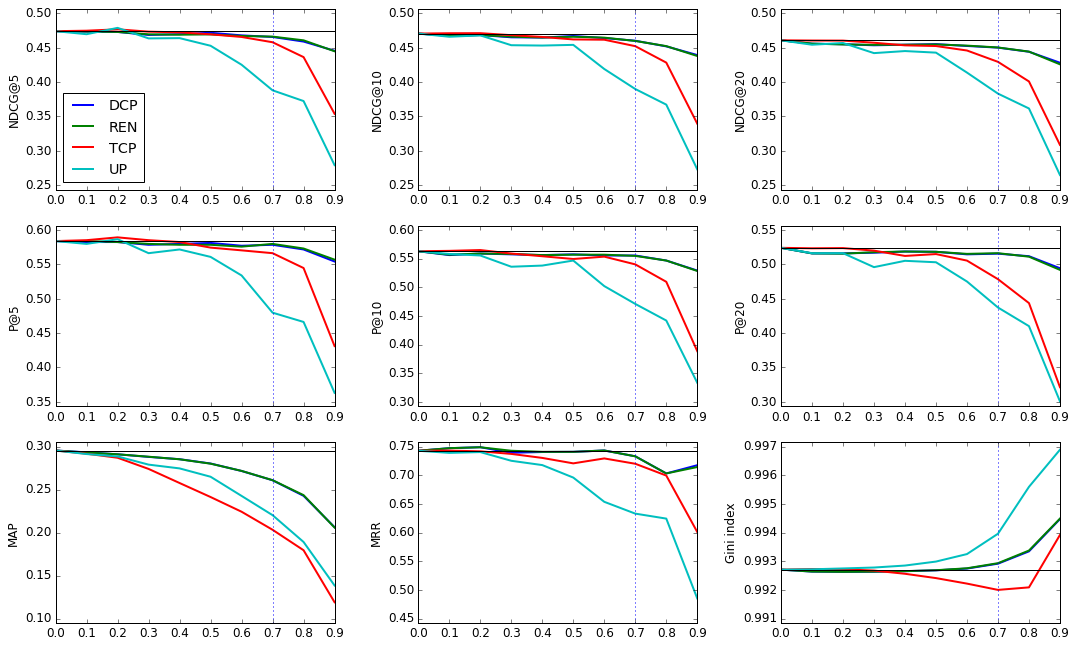

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 11))

for k, m in enumerate(['n@5', 'n@10', 'n@20',
                       'p@5', 'p@10', 'p@20',
                       'map', 'mrr', 'gini']):
    legend = k in [0]
    ax = axes[k / 3, k % 3]
    subdf[m].plot(ax=ax, x='p_ratio', legend=legend, lw=2)
    ax.axhline(baseline[m].iloc[0], color='black')
    ax.set(xlabel='', ylabel=metric_name[m])
    ymin, ymax = ax.get_ylim()
    ax.axvline(x=0.7, linestyle='dotted')
    ax.set_ylim(expand_lim(ax.get_ylim(), 0.05))

fig.subplots_adjust(hspace=0.2, wspace=0.3)